# House Price Analysis with Linear Regression

--------------------------------------------

The focus of this project will be centered around first time home buyers. 

## Data Cleaning
Data is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

What are all these columns?
Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - date house was sold
* **price** - price is prediction target
* **bedrooms** - number of Bedrooms/House
* **bathrooms** - number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** -  square footage of the lot
* **floors** - total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has a view
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


### Datetime

The "date" column is currently an object. Let's change it to datetime, then extract the month and year so we can use those easily. Then, drop the original date column.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

### Odd values 

In [7]:
df.sqft_basement.value_counts(normalize= True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
1990.0    0.000046
2720.0    0.000046
935.0     0.000046
602.0     0.000046
1930.0    0.000046
Name: sqft_basement, Length: 304, dtype: float64

0.2% of the data is marked as '?' while 59.3% is marked as '0.0'. 

In [8]:
# change ? in column to 0 - most commonly seen value
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [9]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1990.0        1
2720.0        1
602.0         1
225.0         1
1930.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [10]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float64')

In [11]:
# see how many rows have a value for sqft_basement
len (df.loc[df['sqft_basement'] > 0])

8317

Let's look elsewhere and see if there is anything else odd.

In [12]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,6.573969,2014.322962
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,3.115061,0.467619
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,2014.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000,2014.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000,2014.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,2015.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,2015.000000


That house with 33 bedrooms is definitely odd. Let's check it out.

In [13]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
# Let's look at any house that had 10+ bedrooms and see how the 
# house with 33 bedrooms compares
df[df['bedrooms'] >= 10]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
8748,1773100755,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,8,2014
13301,627300145,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400,8,2014
15147,5566100170,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914,10,2014
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,6,2014
19239,8812401450,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745,12,2014


Some ways it doesn't differ too much from the other houses:
* best condition
* similar grade
* median in terms of lot size
* fairly similar number of bathrooms

But, in some ways, it is concerning:
* lowest amount of square footage
* only 1 story / floor
* only 1.75 bathrooms for 33 rooms?
* But, mainly, 33 rooms?!? 

It's too suspicious. Let's just remove it.

In [15]:
# Drop the 33 bedroom house then verify that it is gone
df.drop(index=15856, inplace= True)
# df[df['bedrooms'] >= 10]

### Null values

In [16]:
# look at values in waterfront
df.waterfront.value_counts(normalize= True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [17]:
# look at values in view
df.view.value_counts(normalize= True)

0.0    0.901918
2.0    0.044443
3.0    0.023592
1.0    0.015325
4.0    0.014722
Name: view, dtype: float64

In [18]:
# look at values in yr_renovated column
df.yr_renovated.value_counts(normalize= True)

0.0       0.958094
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

99.2% of homes are not considered waterfront properties.

90% of homes do not have a view. While there are more categories, and replacing the null values with 0 may still be iffy, there are not very many missing values.

95.8% of homes have never been renovated. 

We can feel secure in replacing those all the missing values with zeros.

In [19]:
df.fillna(0, inplace= True)

### Duplicates

Most columns will likely have duplicates - especially the categorical columns. But the 'id' should have only one id per entry. Let's check that out.

In [20]:
# check id column for duplicate entries
df.id.duplicated().sum()

177

In [21]:
df_id_dups = df[df.duplicated('id')]

In [22]:
df_id_dups.reset_index(drop= True, inplace= True)

In [23]:
df.loc[df['id'] == 6021501535]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
93,6021501535,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,7,2014
94,6021501535,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,12,2014


In [24]:
df.loc[df['id'] == 4139480200]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,6,2014
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,12,2014


In [25]:
df.loc[df['id'] == 3969300030]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
345,3969300030,165000.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,7,2014
346,3969300030,239900.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,12,2014


It looks like the rows that have identical id numbers were sold a few months apart. I'm going to drop the older data. (AKA the first entries)

In [26]:
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [27]:
df.id.duplicated().sum()

0

In [28]:
df.reset_index(inplace= True, drop= True)

Great! We took care of duplicates, null values, odd values, and have correct data types.

We can move on to taking a closer look at the data.

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Data visualization is the graphical representation of data in order to interactively and efficiently convey insights to others.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21419 entries, 0 to 21418
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21419 non-null  int64  
 1   price          21419 non-null  float64
 2   bedrooms       21419 non-null  int64  
 3   bathrooms      21419 non-null  float64
 4   sqft_living    21419 non-null  int64  
 5   sqft_lot       21419 non-null  int64  
 6   floors         21419 non-null  float64
 7   waterfront     21419 non-null  float64
 8   view           21419 non-null  float64
 9   condition      21419 non-null  int64  
 10  grade          21419 non-null  int64  
 11  sqft_above     21419 non-null  int64  
 12  sqft_basement  21419 non-null  float64
 13  yr_built       21419 non-null  int64  
 14  yr_renovated   21419 non-null  float64
 15  zipcode        21419 non-null  int64  
 16  lat            21419 non-null  float64
 17  long           21419 non-null  float64
 18  sqft_l

### Questions?

Given the information we have and that we are looking at data that would be interesting to first time home buyers, let's generate some questions that might conclude some interesting answers.

1. Which season is best to buy a house if you want the lowest price?
2. Does a waterfront or view matter? Could a first time home buyer afford that?
3. Are there some grades or conditions that might be out of reach for a first time home buyer?
4. Is there an area that we can focus on or eliminate?

#### Criteria assumptions
Before we dive into those questions, it would be helpful to get rid of the information that is not pertinent to a first time home buyer. These could be things like:
* houses over a certain price
* houses with a large square footage
* houses with a lot of bedrooms

So, let's work on removing the irrelevant data.

<AxesSubplot:xlabel='price'>

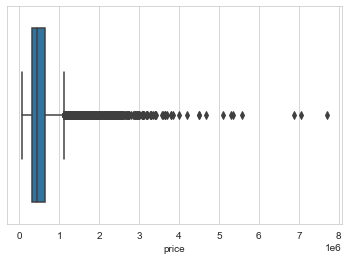

In [30]:
#  Visualize price and outliers
#  Assume for first time home buyer - budget is not more than $500,000
sns.boxplot(x= df['price'])

In [31]:
# remove houses that sold for > $800,000
df = df[df['price'] <= 800000]

<AxesSubplot:xlabel='sqft_living'>

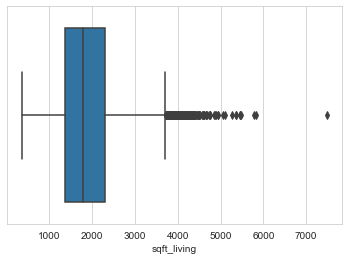

In [32]:
# Visualize houses with high square footage
sns.boxplot(x= df['sqft_living'])

In [33]:
# Whoa! Those are some large houses! Let's cut out the outliers
df = df[df['sqft_living'] <= 4000]

<AxesSubplot:xlabel='bedrooms'>

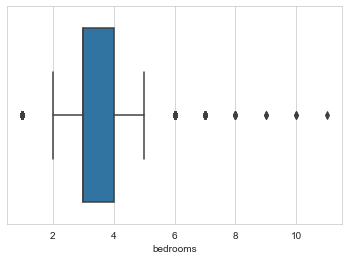

In [34]:
# Visualize bedrooms after houses with large price tags were removed
sns.boxplot(x= df['bedrooms'])

In [35]:
# remove houses with more than 6 bedrooms
df = df[df['bedrooms'] <= 6]

<AxesSubplot:xlabel='sqft_lot'>

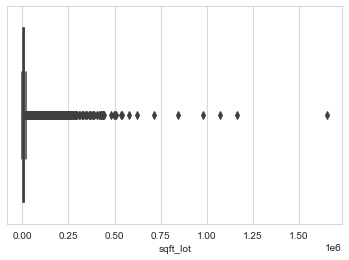

In [36]:
#check lot sizes
sns.boxplot(x= df['sqft_lot'])

In [37]:
df.loc[df['sqft_lot'] > 750000]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
1702,1020069017,700000.0,4,1.00,1300,1651359,1.0,0.0,3.0,4,6,1300,0.0,1920,0.0,98022,47.2313,-122.023,2560,425581,3,2015
4401,3626079040,790000.0,2,3.00,2560,982278,1.0,0.0,0.0,3,8,2560,0.0,2004,0.0,98014,47.6955,-121.861,1620,40946,7,2014
4500,2522029039,550000.0,3,2.00,3650,843309,2.0,0.0,0.0,4,7,3650,0.0,1991,0.0,98070,47.3627,-122.496,1870,273992,9,2014
7582,2623069031,542500.0,5,3.25,3010,1074218,1.5,0.0,0.0,5,8,2010,1000.0,1931,0.0,98027,47.4564,-122.004,2450,68825,5,2014
17149,3326079016,190000.0,2,1.00,710,1164794,1.0,0.0,0.0,2,5,710,0.0,1915,0.0,98014,47.6888,-121.909,1680,16730,5,2015


Only 5 lots have more than 750,000 square feet (which equals about 17.2 acres). That is still plenty of land for those first time home buyers. Let's remove those 5 houses with very large lots.

<AxesSubplot:xlabel='sqft_lot'>

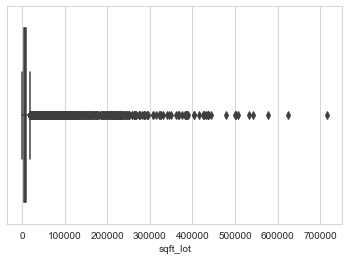

In [124]:
df = df[df['sqft_lot'] < 750000]
sns.boxplot(x= df['sqft_lot'])

#### 1. Which season is best to buy a house if you want the lowest price?

To answer this question, we will have to break the months up into seasons. Then we will find which season has the lowest average sale price.

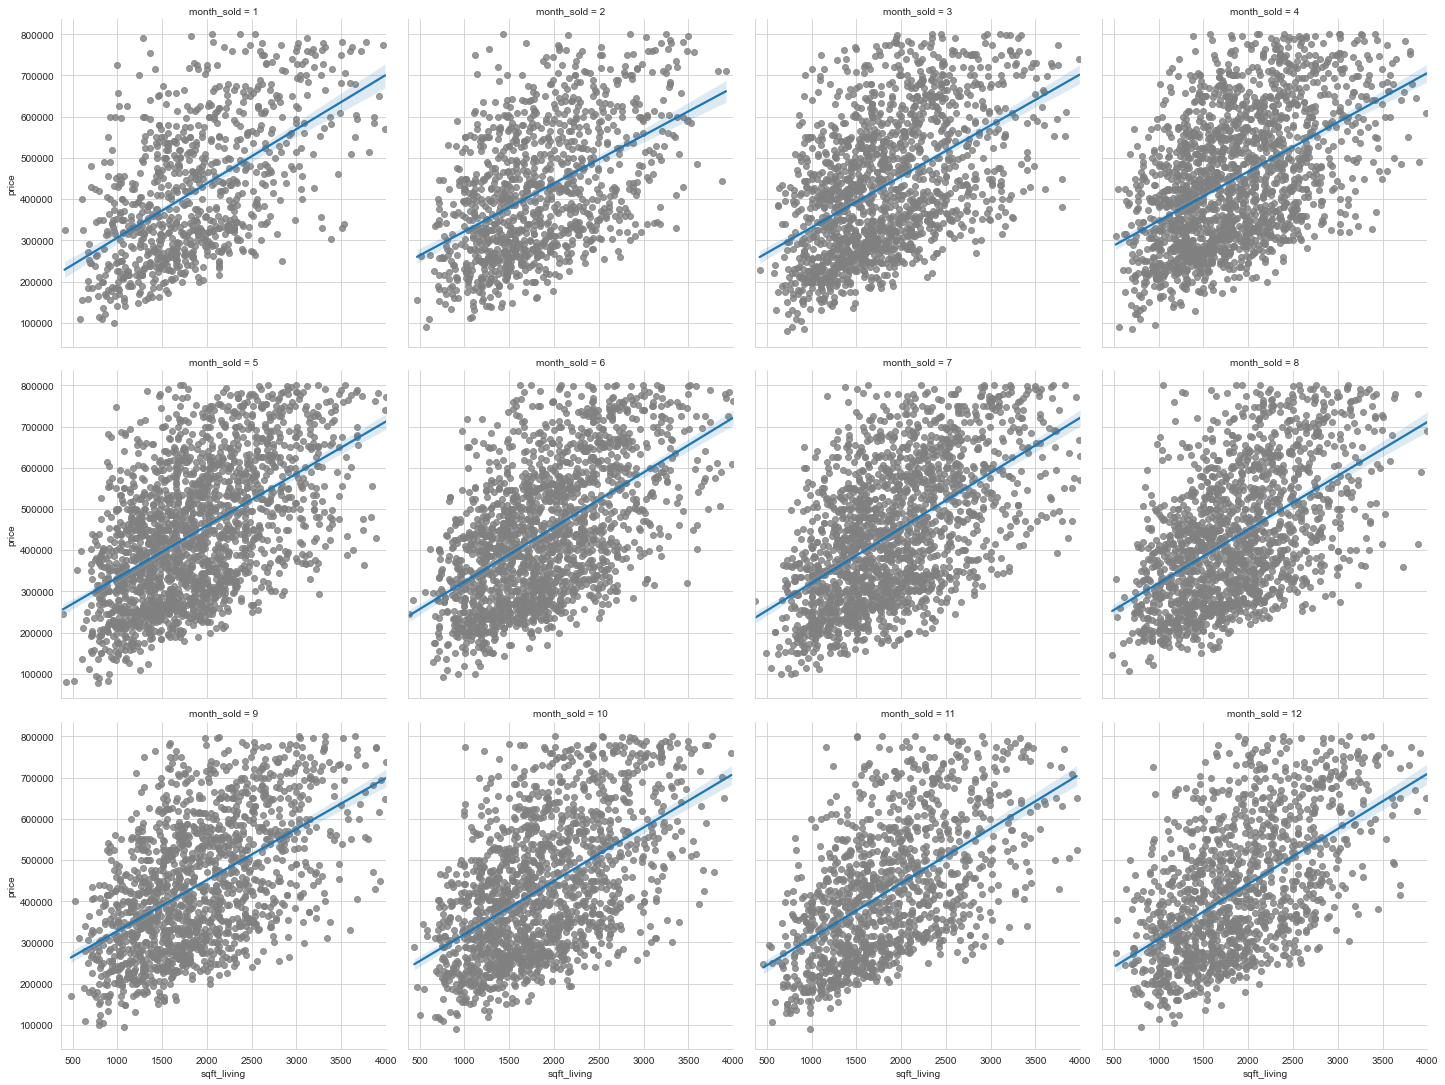

In [40]:
# First, let's look at the months and see if there appears to be a trend
g1 = sns.lmplot(x= 'sqft_living', y= 'price', data= df, col= 'month_sold', 
               col_wrap= 4, scatter_kws = {'color': 'gray'})

In [41]:
# set columns for months sold
df.loc[(df['month_sold'] >= 4) & (df['month_sold'] <= 6), 'season'] = 'spring'
df.loc[(df['month_sold'] >= 7) & (df['month_sold'] <= 9), 'season'] = 'summer'
df.loc[(df['month_sold'] == 10) | (df['month_sold'] == 11), 'season'] = 'fall'
df.loc[(df['month_sold'] == 12), 'season'] = 'winter1'
df.loc[(df['month_sold'] <= 3), 'season'] = 'winter2'

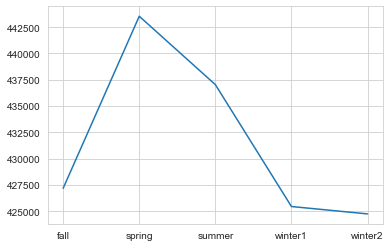

In [42]:
plt.plot(df.groupby('season')['price'].mean().round(2))

<AxesSubplot:xlabel='season', ylabel='price'>

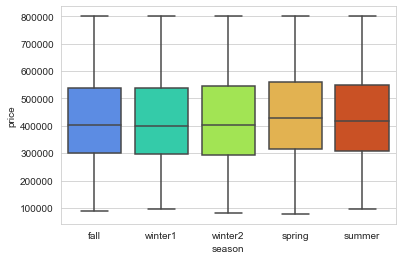

In [43]:
sns.boxplot(x= 'season', y= 'price', data= df, palette= 'turbo')

In [44]:
df_s = df.groupby('season')['price'].mean().round(2)
df_s

season
fall       427192.15
spring     443538.67
summer     437039.30
winter1    425455.78
winter2    424752.70
Name: price, dtype: float64

The most expensive season to buy a house is in spring - April through June - with the average sale price with our criteria being $443,511.71

The least expensive season to buy a house is in "winter2" or the months January through March.
The average home with our search criteria sold for $424,830.72

When comparing the line graph to the boxplot, you can now see that the amount you would be saving is difficult to see in some seasons. The savings would be about $18,000-19,000 between the least expensive time of year (January - March) and the most expensive (April - June). 

However, it is interesting to see that fall, winter1, and winter2 don't vary that much from each other. During October through March, one might expect to pay only 2K-3K more or less.

#### 2. Does a waterfront or view matter? Could a first time home buyer afford that?

Let's see how many waterfront properties or houses with views we have. When we took out higher priced homes, it may not have left much data in those features.

In [45]:
print(len(df[df['waterfront'] == 1]))
len(df[df['view'] > 0])

35


1139

In [46]:
len(df[df['waterfront'] == 1]) / len(df)

0.0019071490845684394

There were only 35 properties that were sold in the first time home buyer's criteria. If they really want a waterfront property, they may have to wait a while.

In [47]:
len(df[df['view'] > 0]) / len(df)

0.0620640802092415

While 6% of the data is still a small portion, we can leave it and see what the analysis says.

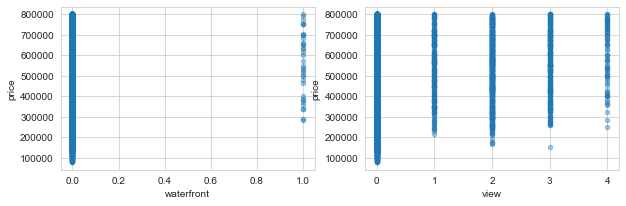

In [48]:
fig, axes = plt.subplots(nrows= 1, ncols= 2, figsize= (10, 3))

for xcol, ax in zip([ 'waterfront', 'view'], axes):
    df.plot(kind= 'scatter', x=xcol, y= 'price', ax=ax, alpha= 0.4)

Looks like getting a house with a view could still be a possibility. It appears that there are some houses priced around $200,000 that have a view rated "2"

#### 3. Are there some grades or conditions that might be out of reach for a first time home buyer?

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

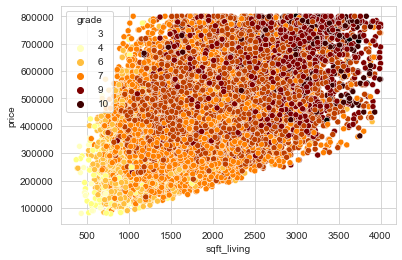

In [49]:
sns.scatterplot(x= 'sqft_living', y= 'price', hue= 'grade', data= df, 
                palette= 'afmhot_r')

Grades do seem to improve with price, but there are some smaller and less expensive homes that have higher grades.

0.001471229293809939

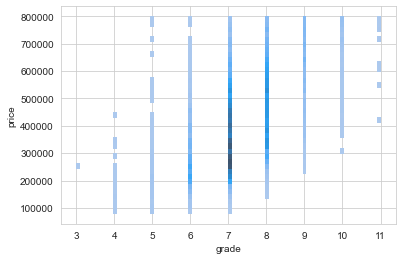

In [50]:
# #Looking at grades of the houses
sns.histplot(x= 'grade', y= 'price', data= df)

# percent of houses sold with a grade "4"
len(df[df['grade'] == 4]) / len(df)

0.009971665213600697

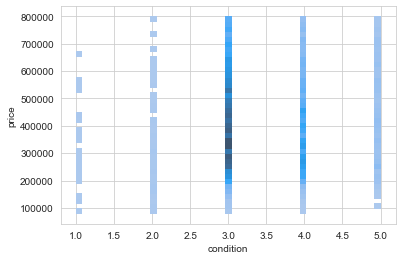

In [51]:
sns.histplot(x= 'condition', y= 'price', data= df)
# percent of houses with a condition of "1 or "2" 
len(df[df['condition'] <= 2]) / len(df)

In [52]:
df.condition.unique()

array([3, 5, 4, 1, 2])

While we may not want a first time home buyer to buy a house in poor condition, there are not many houses that would qualify. Since condition and grade can be subjective, we can leave them in and let the potential new home owner decide.

#### 4. Is there an area that we can focus on or eliminate?

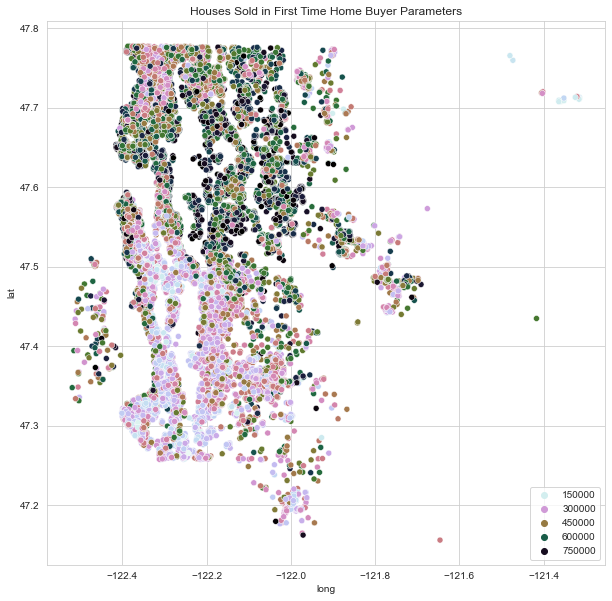

In [53]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix_r')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

Appears that the houses that sold for more are on the Northern side. We can separate the areas to see if we are correct.

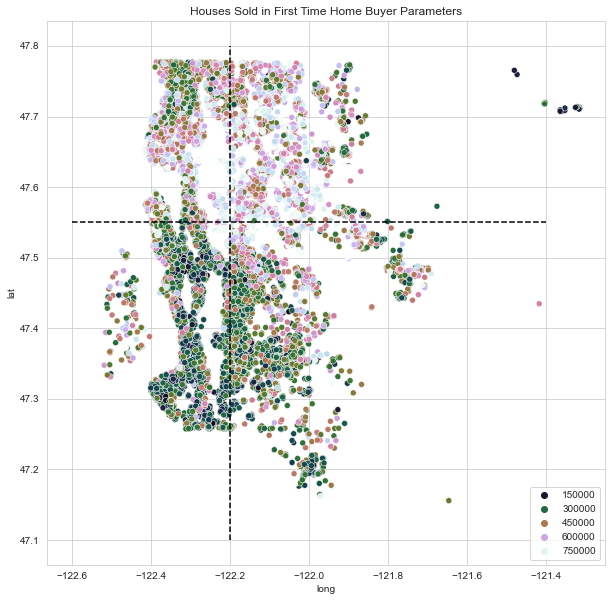

In [54]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix')
plt.hlines(y=47.55, xmin=-122.6, xmax=-121.4, colors='black', linestyle='--')
plt.vlines(x=-122.2, ymin=47.1, ymax=47.8, colors='black', linestyle='--')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

That appears to separate the areas fairly evenly. Let's turn the latitude and longitude into quadrants and use the quadrants instead of zipcodes as locators.

In [55]:
df.loc[(df['lat'] >= 47.5) & (df['long'] >= -122.2), 'quadrant' ] = 'NW'
df.loc[(df['lat'] > 47.5) & (df['long'] < -122.2), 'quadrant' ] = 'NE'
df.loc[(df['lat'] <= 47.5) & (df['long'] <= -122.2), 'quadrant' ] = 'SW'
df.loc[(df['lat'] < 47.5) & (df['long'] > -122.2), 'quadrant' ] = 'SE'

In [56]:
# did it work?
# df_q3 = df[df['quadrant'] == 3]
# sns.scatterplot(x='long', y='lat', hue='price', data=df_q3, 
#                 palette= 'cubehelix')

The theory is that houses in quadrants 3 and 4 will be more affordable than those in quadrants 1 and 2.

<AxesSubplot:xlabel='quadrant', ylabel='price'>

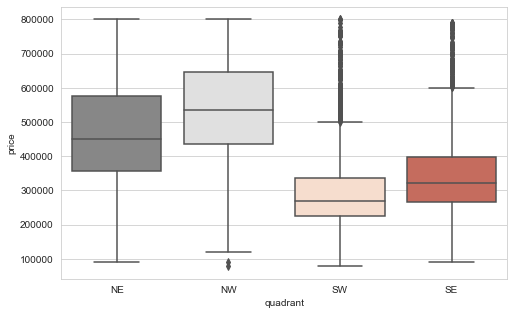

In [57]:
plt.figure(figsize= (8,5))
sns.boxplot(x= 'quadrant', y= 'price', data= df, palette= 'RdGy_r')

Looks like we were right. If we are only looking at homes that are less than $800,000, then houses in the Southern quadrants would, generally, be the least expensive.

In [58]:
# Save a copy of cleaned and organized data before one-hot encoding or 
# dropping columns

df.to_csv('clean_df.csv')

## Feature Selection & Engineering

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

### Separate Continuous and Categorical Data

In [59]:
# use this to see which columns could be categorical or continuous data
continuous = []
categorical = []

for col in df.columns:
    if (df[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [60]:
continuous

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [61]:
categorical

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'month_sold',
 'year_sold',
 'season',
 'quadrant']

Almost perfect. But I think there are some columns labeled categorical that I would consider continuous.

In [62]:
# Continuous data
con = ['id', 'price', 'sqft_living', 'sqft_lot','sqft_basement', 'yr_built', 
       'zipcode','lat','long']

In [63]:
# Categorical data
cat = ['waterfront','view','condition','grade', 'month_sold', 'year_sold', 
       'season','quadrant', 'bedrooms','bathrooms','floors', 'yr_renovated']

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>]], dtype=object)

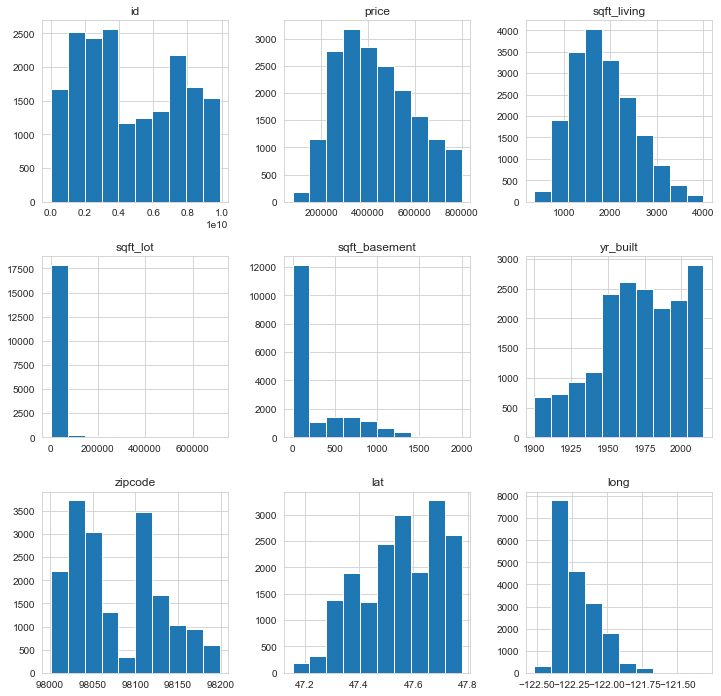

In [64]:
# Look at continuous variables
df_continuous = df.loc[:, con]
df_continuous.hist(figsize= (12, 12))

With the exception of "sqft_lot", these indeed look like they are continuous.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18352 entries, 0 to 21418
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             18352 non-null  int64  
 1   price          18352 non-null  float64
 2   bedrooms       18352 non-null  int64  
 3   bathrooms      18352 non-null  float64
 4   sqft_living    18352 non-null  int64  
 5   sqft_lot       18352 non-null  int64  
 6   floors         18352 non-null  float64
 7   waterfront     18352 non-null  float64
 8   view           18352 non-null  float64
 9   condition      18352 non-null  int64  
 10  grade          18352 non-null  int64  
 11  sqft_above     18352 non-null  int64  
 12  sqft_basement  18352 non-null  float64
 13  yr_built       18352 non-null  int64  
 14  yr_renovated   18352 non-null  float64
 15  zipcode        18352 non-null  int64  
 16  lat            18352 non-null  float64
 17  long           18352 non-null  float64
 18  sqft_l

array([[<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'month_sold'}>,
        <AxesSubplot:title={'center':'year_sold'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

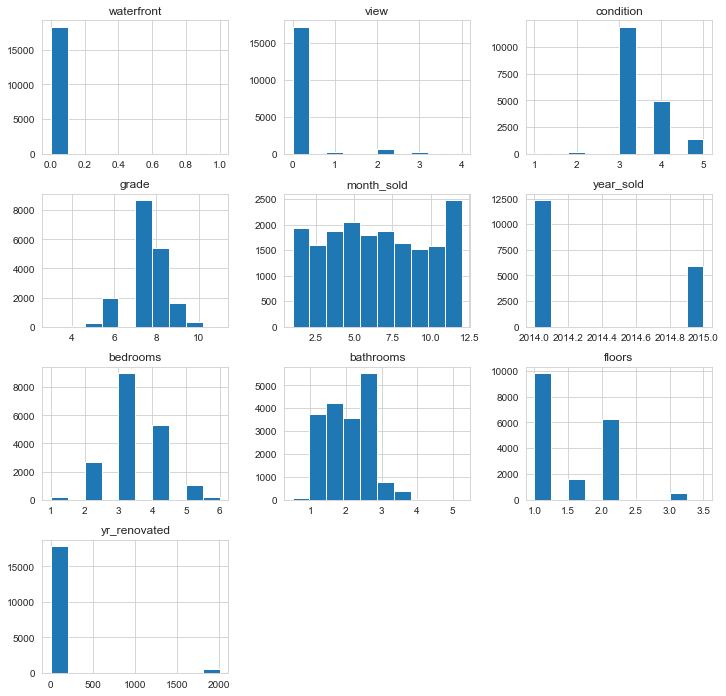

In [66]:
df_categorical = df.loc[:, cat]
df_categorical.hist(figsize= (12, 12))

Some of them could be cleaned up. But let's see what our baseline is and adjust from there.

### Baseline checks

#### Multicollinearity 

Check for interactions between other features.

In [67]:
corr = df.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
id,1.000000,0.036821,0.015408,0.037375,0.026354,-0.146857,0.038201,-0.007719,0.021851,-0.034351,0.051994,0.032193,-0.007173,0.031224,-0.009740,-0.005258,0.006179,0.020733,0.023040,-0.143749,-0.008737,0.005740
price,0.036821,1.000000,0.246234,0.384998,0.528371,0.083327,0.240558,0.034484,0.170629,0.028175,0.545937,0.429549,0.199535,0.052394,0.046760,0.004596,0.472662,0.073720,0.481903,0.068646,-0.006923,-0.001436
bedrooms,0.015408,0.246234,1.000000,0.481472,0.610827,0.020886,0.135254,-0.032920,0.011914,0.023234,0.301024,0.472277,0.269517,0.178501,-0.013281,-0.163926,-0.067629,0.152148,0.376363,0.014544,-0.003990,-0.003923
bathrooms,0.037375,0.384998,0.481472,1.000000,0.687898,0.042172,0.501995,-0.024663,0.046425,-0.143519,0.582412,0.606960,0.181836,0.578578,-0.003417,-0.223568,-0.047454,0.250843,0.502159,0.039359,0.012410,-0.028468
sqft_living,0.026354,0.528371,0.610827,0.687898,1.000000,0.148075,0.310084,-0.008897,0.113719,-0.073322,0.642017,0.828702,0.353940,0.365213,0.003100,-0.221519,-0.047431,0.289546,0.713092,0.147815,0.016802,-0.029361
sqft_lot,-0.146857,0.083327,0.020886,0.042172,0.148075,1.000000,-0.037091,0.020089,0.097607,0.003857,0.073721,0.152077,0.003278,0.034539,0.016697,-0.142776,-0.112327,0.239454,0.158193,0.770239,0.011487,-0.006458
floors,0.038201,0.240558,0.135254,0.501995,0.310084,-0.037091,1.000000,-0.012299,-0.023886,-0.284769,0.446970,0.519659,-0.321829,0.531922,-0.014894,-0.069590,0.017266,0.130786,0.244623,-0.037478,0.014828,-0.022732
waterfront,-0.007719,0.034484,-0.032920,-0.024663,-0.008897,0.020089,-0.012299,1.000000,0.274040,0.011395,-0.018683,-0.016955,0.013482,-0.037863,0.047057,0.029547,-0.038447,-0.056208,0.000409,0.039257,0.005522,-0.003694
view,0.021851,0.170629,0.011914,0.046425,0.113719,0.097607,-0.023886,0.274040,1.000000,0.021224,0.083939,0.034079,0.138447,-0.070402,0.038571,0.098960,-0.046155,-0.072353,0.144975,0.090328,0.000285,0.005164
condition,-0.034351,0.028175,0.023234,-0.143519,-0.073322,0.003857,-0.284769,0.011395,0.021224,1.000000,-0.186075,-0.181126,0.168558,-0.346112,-0.048182,-0.008712,-0.021839,-0.086231,-0.131354,0.009712,0.026113,-0.047910


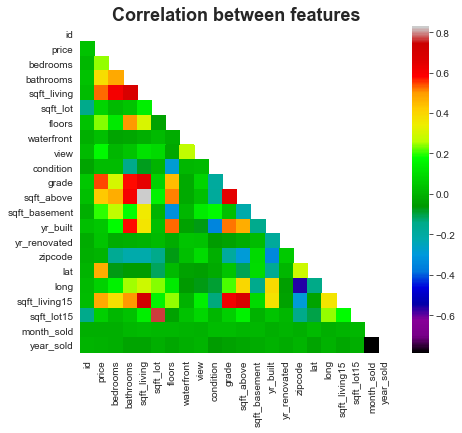

In [68]:
plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

There are some areas of high correlation. The highest is where "sqft_above" meets "sqft_living". "sqft_living15" also correlates highly across other features. Those will be columns we look forward to removing.

In [69]:
df.drop(columns= ['sqft_above', 'sqft_living15', 'month_sold', 'season',
                  'sqft_lot15', 'quadrant'], inplace= True)
# df.info()

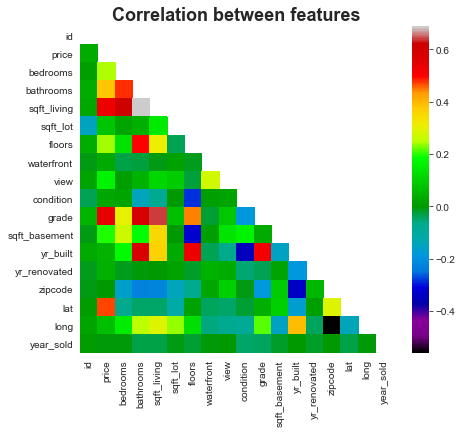

In [70]:
corr1 = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

#### Baseline Model

In [71]:
df1 = df.copy()
outcome = 'price'
x_cols = df1.drop(['price'], axis= 1).columns
x_cols

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'year_sold'],
      dtype='object')

In [72]:
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= df1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1970.
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:44:23   Log-Likelihood:            -2.3651e+05
No. Observations:               18352   AIC:                         4.731e+05
Df Residuals:                   18334   BIC:                         4.732e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.658e+07   3.39e+06    -10.787      0.000   -4.32e+07   -2.99e+07
id             8.925e-07    2.5e-07      3.574      0.000    4.03e-07    1.38e-06
bedrooms      -1.068e+04   1099.175     -9.717      0.000   -1.28e+04   -8525.787
bathrooms      2.319e+04   1796.779     12.905      0.000    1.97e+04    2.67e+04
sqft_living      79.1536      2.049     38.633      0.000      75.138      83.170
sqft_lot          0.2550      0.024     10.781      0.000       0.209       0.301
floors         2.579e+04   1894.876     13.610      0.000    2.21e+04    2.95e+04
waterfront     1.024e+05   1.69e+04      6.061      0.000    6.93e+04    1.36e+05
view           2.754e+04   1365.521     20.166      0.000    2.49e+04    3.02e+04
condition      2.045e+04   1214.753     16.837      0.000    1.81e+04    2.28e+04
grade          6.466e+04   1160.642     55.713      0.000    6.24e+04    6.69e+04
sqft_basement    -3.6573      2.499     -1.463      0.143      -8.556       1.242
yr_built      -1475.4041     39.246    -37.594      0.000   -1552.330   -1398.478
yr_renovated      3.9118      2.294      1.705      0.088      -0.584       8.408
zipcode        -161.6344     16.968     -9.526      0.000    -194.893    -128.376
lat            5.129e+05   5337.401     96.097      0.000    5.02e+05    5.23e+05
long           1.341e+04   6577.892      2.039      0.041     517.775    2.63e+04
year_sold      1.602e+04   1513.221     10.587      0.000    1.31e+04     1.9e+04
==============================================================================
Omnibus:                      520.536   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              680.516
Skew:                           0.334   Prob(JB):                    1.69e-148
Kurtosis:                       3.666   Cond. No.                     2.61e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Baseline $R^{2}$ = 0.646

Let's see if we can't improve that a little (or a lot).

### One-hot encoding and binning

Time to work with the data within some of these features to clean it up.
Features we'll focus on are:
* bathrooms
* floors
* grades
* sqft_basement
* view
* yr_renovated

#### Bathrooms and Floors

In [73]:
# make changes to df copy and see if model does better
df1 = df.copy()

In [74]:
# look at bathroom data
df1.bathrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 1.5 , 2.5 , 1.75, 2.75, 3.25, 3.5 , 0.75,
       4.  , 1.25, 3.75, 4.5 , 4.75, 0.5 , 5.  , 4.25, 5.25])

In [75]:
# Only count whole bathrooms
df1['bathrooms'] = df1.bathrooms.astype(int)
df1.bathrooms.unique()

array([1, 2, 3, 0, 4, 5])

In [76]:
# A house shouldn't have 0 bathrooms. Let's change the zeros to ones.
df1['bathrooms'] = df1['bathrooms'].map(lambda x: 1 if x == 0 else x)

In [77]:
# check out the values of floors
df1.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [78]:
# Change floors that end in .5 to even number
df1['floors'] = df1['floors'].map(lambda x: x + 0.5)
df1['floors'] = df1.floors.astype(int)
df1.floors.unique()

array([1, 2, 3, 4])

In [79]:
outcome = 'price'
x_cols = df1.drop(['price'], axis= 1).columns

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df1).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1961.
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:44:23   Log-Likelihood:            -2.3653e+05
No. Observations:               18352   AIC:                         4.731e+05
Df Residuals:                   18334   BIC:                         4.732e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.617e+07   3.39e+06    -10.654      0.000   -4.28e+07   -2.95e+07
id             8.962e-07    2.5e-07      3.583      0.000    4.06e-07    1.39e-06
bedrooms      -1.017e+04   1092.484     -9.313      0.000   -1.23e+04   -8032.732
bathrooms      1.571e+04   1605.446      9.788      0.000    1.26e+04    1.89e+04
sqft_living      82.5175      2.010     41.049      0.000      78.577      86.458
sqft_lot          0.2446      0.024     10.338      0.000       0.198       0.291
floors         2.563e+04   1638.314     15.645      0.000    2.24e+04    2.88e+04
waterfront     1.019e+05   1.69e+04      6.025      0.000    6.88e+04    1.35e+05
view           2.788e+04   1367.156     20.389      0.000    2.52e+04    3.06e+04
condition      2.118e+04   1213.002     17.463      0.000    1.88e+04    2.36e+04
grade          6.551e+04   1159.706     56.488      0.000    6.32e+04    6.78e+04
sqft_basement    -0.1008      2.465     -0.041      0.967      -4.932       4.730
yr_built      -1310.0112     36.771    -35.626      0.000   -1382.086   -1237.936
yr_renovated      5.7919      2.290      2.529      0.011       1.303      10.281
zipcode        -168.6546     16.985     -9.929      0.000    -201.948    -135.362
lat            5.143e+05   5339.030     96.325      0.000    5.04e+05    5.25e+05
long           1.241e+04   6578.049      1.887      0.059    -479.665    2.53e+04
year_sold       1.59e+04   1515.278     10.496      0.000    1.29e+04    1.89e+04
==============================================================================
Omnibus:                      502.295   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.330
Skew:                           0.327   Prob(JB):                    8.20e-143
Kurtosis:                       3.654   Cond. No.                     2.61e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The $R^{2}$ on this model = 0.645

That is only .001 lower than our original and we haven't dropped anything yet.

But let's see if need to clean up other features, like grade or condition.

#### Grade Binning

In [80]:
print ('waterfront: ', df1.waterfront.unique())
print ('condition: ', df.condition.unique())

waterfront:  [0. 1.]
condition:  [3 5 4 1 2]


In [81]:
print ('grade values: ', df1['grade'].unique())

grade values:  [ 7  6  8  9  5 10  4 11  3]


5__7     10688
7__9      7056
9__11      347
3__5       261
Name: grade, dtype: int64
Sum:  18352


<AxesSubplot:xlabel='grade', ylabel='count'>

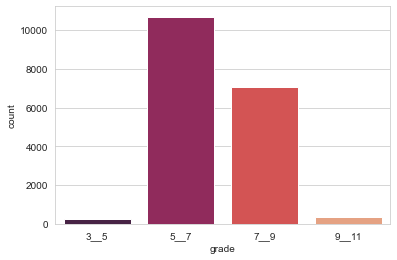

In [82]:
# Let's change waterfront to integers and bin some grades
df1['waterfront'] = df1.waterfront.astype(int)

grade_binned = pd.cut(df['grade'], bins= 4, labels = ['3__5', '5__7', '7__9',
                                                      '9__11'])
print(grade_binned.value_counts())
print ('Sum: ', grade_binned.value_counts().sum())
sns.countplot(x= grade_binned, palette= 'rocket')

In [83]:
df2 = df1.copy()

In [84]:
df2.drop(columns= ['grade'], axis= 1, inplace= True)

In [85]:
df2 = pd.concat([df2, grade_binned], names= ['grade_bin'], axis= 1)

In [86]:
df2.rename(columns={'grade': 'grade_binned'}, inplace= True)

In [87]:
# grade_dummies = pd.get_dummies(df2['grade_binned'], prefix= 'grade_', 
#                                drop_first= True)

In [88]:
# df2.drop(['grade_binned'], axis= 1, inplace= True)

In [89]:
# df2 = pd.concat([df2, grade_dummies], axis= 1)

In [90]:
# df2.head()

<AxesSubplot:>

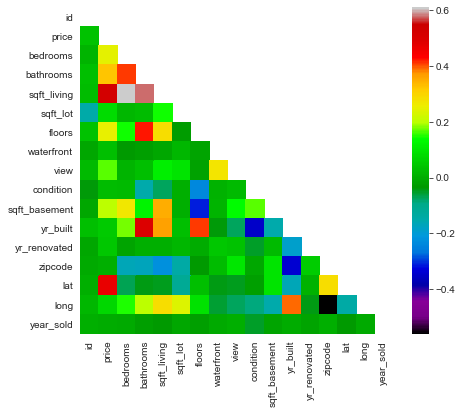

In [91]:
corr2 = df2.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr2, dtype=bool))
sns.heatmap(df2.corr(), cmap= 'nipy_spectral', mask= mask)

In [92]:
outcome = 'price'
x_cols = df2.drop(['price'], axis= 1).columns

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df2).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1598.
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:44:24   Log-Likelihood:            -2.3708e+05
No. Observations:               18352   AIC:                         4.742e+05
Df Residuals:                   18332   BIC:                         4.744e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3.477e+07    3.5e+06     -9.939      0.000   -4.16e+07   -2.79e+07
grade_binned[T.5__7]   6.953e+04   6346.827     10.955      0.000    5.71e+04     8.2e+04
grade_binned[T.7__9]   1.482e+05   6688.837     22.150      0.000    1.35e+05    1.61e+05
grade_binned[T.9__11]  2.354e+05   8786.663     26.794      0.000    2.18e+05    2.53e+05
id                     9.694e-07   2.58e-07      3.762      0.000    4.64e-07    1.47e-06
bedrooms              -1.032e+04   1134.906     -9.089      0.000   -1.25e+04   -8091.157
bathrooms              1.377e+04   1657.326      8.309      0.000    1.05e+04     1.7e+04
sqft_living             102.7898      1.980     51.906      0.000      98.908     106.671
sqft_lot                  0.2490      0.024     10.217      0.000       0.201       0.297
floors                 2.512e+04   1694.930     14.823      0.000    2.18e+04    2.84e+04
waterfront              9.26e+04   1.74e+04      5.312      0.000    5.84e+04    1.27e+05
view                   2.958e+04   1408.601     20.999      0.000    2.68e+04    3.23e+04
condition              2.182e+04   1250.810     17.444      0.000    1.94e+04    2.43e+04
sqft_basement            -8.1017      2.533     -3.198      0.001     -13.067      -3.137
yr_built              -1048.8970     37.354    -28.080      0.000   -1122.114    -975.679
yr_renovated              7.4852      2.361      3.170      0.002       2.857      12.114
zipcode                -191.9396     17.492    -10.973      0.000    -226.226    -157.653
lat                    5.361e+05   5465.922     98.089      0.000    5.25e+05    5.47e+05
long                  -3884.7421   6774.196     -0.573      0.566   -1.72e+04    9393.315
year_sold              1.475e+04   1560.496      9.455      0.000    1.17e+04    1.78e+04
==============================================================================
Omnibus:                      412.959   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.784
Skew:                           0.310   Prob(JB):                    4.90e-109
Kurtosis:                       3.518   Cond. No.                     2.61e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Whoa. We went from an $R^2$ of 0.646 to 0.624. Maybe we don't want to bin the grades. Let's go back to using the previous DataFrame.

#### Basement, views, and renovations

Let's turn sqft_basement, yr_renovated, and view into either has or doesn't have.

In [93]:
df3 = df1.copy()

In [94]:
print ('Num of basement values: ', df.sqft_basement.nunique())
df3['has_basement'] = df3['sqft_basement'].map(lambda x: 1 if x > 0 else 0)

Num of basement values:  228


In [95]:
print ('View values: ', df.view.unique())
df3['has_view'] = df3['view'].map(lambda x: 1 if x > 0 else 0)

View values:  [0. 3. 2. 4. 1.]


In [96]:
print ('Num of renovation values: ', df3.yr_renovated.nunique())
df3['had_renovation'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)

Num of renovation values:  69


In [97]:
df3.drop(columns= ['yr_renovated', 'view', 'sqft_basement'], axis= 1, inplace= True)

In [98]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18352 entries, 0 to 21418
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18352 non-null  int64  
 1   price           18352 non-null  float64
 2   bedrooms        18352 non-null  int64  
 3   bathrooms       18352 non-null  int64  
 4   sqft_living     18352 non-null  int64  
 5   sqft_lot        18352 non-null  int64  
 6   floors          18352 non-null  int64  
 7   waterfront      18352 non-null  int64  
 8   condition       18352 non-null  int64  
 9   grade           18352 non-null  int64  
 10  yr_built        18352 non-null  int64  
 11  zipcode         18352 non-null  int64  
 12  lat             18352 non-null  float64
 13  long            18352 non-null  float64
 14  year_sold       18352 non-null  int64  
 15  has_basement    18352 non-null  int64  
 16  has_view        18352 non-null  int64  
 17  had_renovation  18352 non-null 

In [99]:
outcome = 'price'
x_cols = df3.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df3).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1975.
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:44:24   Log-Likelihood:            -2.3649e+05
No. Observations:               18352   AIC:                         4.730e+05
Df Residuals:                   18334   BIC:                         4.732e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.382e+07   3.39e+06     -9.978      0.000   -4.05e+07   -2.72e+07
id              8.796e-07    2.5e-07      3.525      0.000    3.91e-07    1.37e-06
bedrooms       -1.014e+04   1089.664     -9.308      0.000   -1.23e+04   -8006.666
bathrooms       1.418e+04   1605.168      8.835      0.000     1.1e+04    1.73e+04
sqft_living       78.9643      1.873     42.148      0.000      75.292      82.636
sqft_lot           0.2521      0.024     10.692      0.000       0.206       0.298
floors          3.026e+04   1579.461     19.158      0.000    2.72e+04    3.34e+04
waterfront      1.392e+05   1.65e+04      8.448      0.000    1.07e+05    1.71e+05
condition       2.077e+04   1206.522     17.218      0.000    1.84e+04    2.31e+04
grade           6.607e+04   1145.570     57.672      0.000    6.38e+04    6.83e+04
yr_built       -1307.2184     36.685    -35.633      0.000   -1379.125   -1235.312
zipcode         -176.1827     16.953    -10.392      0.000    -209.412    -142.953
lat             5.087e+05   5319.418     95.624      0.000    4.98e+05    5.19e+05
long            2.405e+04   6560.855      3.666      0.000    1.12e+04    3.69e+04
year_sold       1.594e+04   1511.721     10.542      0.000     1.3e+04    1.89e+04
has_basement    1.306e+04   1715.622      7.610      0.000    9692.994    1.64e+04
has_view        6.348e+04   3074.471     20.646      0.000    5.74e+04    6.95e+04
had_renovation   1.18e+04   4556.114      2.591      0.010    2874.515    2.07e+04
==============================================================================
Omnibus:                      513.065   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.128
Skew:                           0.327   Prob(JB):                    3.38e-148
Kurtosis:                       3.679   Cond. No.                     2.62e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This $R^2$ went up slightly from our original (0.001). Let's keep these changes.

#### Use Dummy Variables

In [100]:
# use this to see which columns could be categorical or continuous data
continuous = []
categorical = []

for col in df3.columns:
    if (df3[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [101]:
continuous

['id',
 'price',
 'sqft_living',
 'sqft_lot',
 'yr_built',
 'zipcode',
 'lat',
 'long']

In [102]:
categorical

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'year_sold',
 'has_basement',
 'has_view',
 'had_renovation']

The categorical columns are indeed categorical. Let's use dummy variables and see what happens to our model.

In [103]:
df4 = df3.copy()

In [104]:
#OHE bedrooms, bathrooms, and floors
bed_dum = pd.get_dummies(df4['bedrooms'], prefix= 'bed', drop_first= True)
bath_dum = pd.get_dummies(df4['bathrooms'], prefix= 'bath', drop_first= True)
flr_dum = pd.get_dummies(df4['floors'], prefix= 'flr', drop_first= True)
grade_dum = pd.get_dummies(df4['grade'], prefix= 'grd', drop_first= True)

In [105]:
df4 = df4.drop(['bedrooms', 'bathrooms', 'floors', 'grade'], axis= 1)

In [106]:
df4 = pd.concat([df4, bed_dum, bath_dum, flr_dum, grade_dum], axis= 1)

In [107]:
df4.head()

,id,price,sqft_living,sqft_lot,waterfront,condition,yr_built,zipcode,lat,long,year_sold,has_basement,has_view,had_renovation,bed_2,bed_3,bed_4,bed_5,bed_6,bath_2,bath_3,bath_4,bath_5,flr_2,flr_3,flr_4,grd_4,grd_5,grd_6,grd_7,grd_8,grd_9,grd_10,grd_11
0,7129300520,221900.0,1180,5650,0,3,1955,98178,47.5112,-122.257,2014,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,6414100192,538000.0,2570,7242,0,3,1951,98125,47.7210,-122.319,2014,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,5631500400,180000.0,770,10000,0,3,1933,98028,47.7379,-122.233,2015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2487200875,604000.0,1960,5000,0,5,1965,98136,47.5208,-122.393,2014,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1954400510,510000.0,1680,8080,0,3,1987,98074,47.6168,-122.045,2015,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [108]:
outcome = 'price'
x_cols = df4.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df4).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:44:24   Log-Likelihood:            -2.3644e+05
No. Observations:               18352   AIC:                         4.729e+05
Df Residuals:                   18318   BIC:                         4.732e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.436e+07   3.39e+06    -10.125      0.000    -4.1e+07   -2.77e+07
id              8.706e-07   2.49e-07      3.495      0.000    3.82e-07    1.36e-06
sqft_living       76.2665      1.922     39.677      0.000      72.499      80.034
sqft_lot           0.2556      0.024     10.847      0.000       0.209       0.302
waterfront       1.36e+05   1.64e+04      8.271      0.000    1.04e+05    1.68e+05
condition       2.141e+04   1211.849     17.663      0.000     1.9e+04    2.38e+04
yr_built       -1286.2977     37.941    -33.903      0.000   -1360.665   -1211.930
zipcode         -174.4501     17.012    -10.254      0.000    -207.796    -141.105
lat             5.106e+05   5364.751     95.169      0.000       5e+05    5.21e+05
long            1.895e+04   6649.676      2.850      0.004    5914.427     3.2e+04
year_sold         1.6e+04   1508.286     10.610      0.000     1.3e+04     1.9e+04
has_basement    1.486e+04   1750.050      8.490      0.000    1.14e+04    1.83e+04
has_view        6.271e+04   3074.956     20.395      0.000    5.67e+04    6.87e+04
had_renovation   1.34e+04   4556.452      2.940      0.003    4465.252    2.23e+04
bed_2           6863.5542   7353.350      0.933      0.351   -7549.700    2.13e+04
bed_3          -6244.3909   7349.040     -0.850      0.396   -2.06e+04    8160.415
bed_4          -1.133e+04   7552.705     -1.501      0.133   -2.61e+04    3469.928
bed_5          -2.786e+04   8144.602     -3.420      0.001   -4.38e+04   -1.19e+04
bed_6          -3.245e+04   1.08e+04     -2.998      0.003   -5.37e+04   -1.12e+04
bath_2          1.486e+04   1985.375      7.485      0.000     1.1e+04    1.88e+04
bath_3          2.688e+04   3672.754      7.318      0.000    1.97e+04    3.41e+04
bath_4          2.196e+04   1.39e+04      1.574      0.115   -5380.407    4.93e+04
bath_5          8.367e+04   3.98e+04      2.103      0.036    5670.108    1.62e+05
flr_2           3.123e+04   1808.474     17.268      0.000    2.77e+04    3.48e+04
flr_3           5.205e+04   4501.486     11.562      0.000    4.32e+04    6.09e+04
flr_4           7.387e+04    3.9e+04      1.892      0.058   -2653.618     1.5e+05
grd_4          -1.433e+05   9.72e+04     -1.474      0.141   -3.34e+05    4.73e+04
grd_5          -1.354e+05   9.58e+04     -1.413      0.158   -3.23e+05    5.24e+04
grd_6          -1.033e+05   9.57e+04     -1.080      0.280   -2.91e+05    8.43e+04
grd_7          -3.872e+04   9.57e+04     -0.404      0.686   -2.26e+05    1.49e+05
grd_8            3.11e+04   9.58e+04      0.325      0.745   -1.57e+05    2.19e+05
grd_9           1.071e+05   9.58e+04      1.117      0.264   -8.07e+04    2.95e+05
grd_10          1.568e+05   9.59e+04      1.635      0.102   -3.12e+04    3.45e+05
grd_11          1.892e+05   9.89e+04      1.912      0.056   -4739.339    3.83e+05
============

$R^2$ is at 0.649 and we now have some higher p-values that we could potentially drop.

Other interesting things we can now see:
* having 5 bathrooms makes a dramatic increase in price
* additional bedrooms decrease value
* having a view increases the price drastically
* prices increase starting at grade 8 and above

* now that the grades are separate - none of them meet the 0.05 measurement of statistical significance. 

In [109]:
df_pairplot = df[['price', 'sqft_living', 'yr_built','condition', 'sqft_lot']]

In [110]:
df_pairplot.head()

,price,sqft_living,yr_built,condition,sqft_lot
0,221900.0,1180,1955,3,5650
1,538000.0,2570,1951,3,7242
2,180000.0,770,1933,3,10000
3,604000.0,1960,1965,5,5000
4,510000.0,1680,1987,3,8080


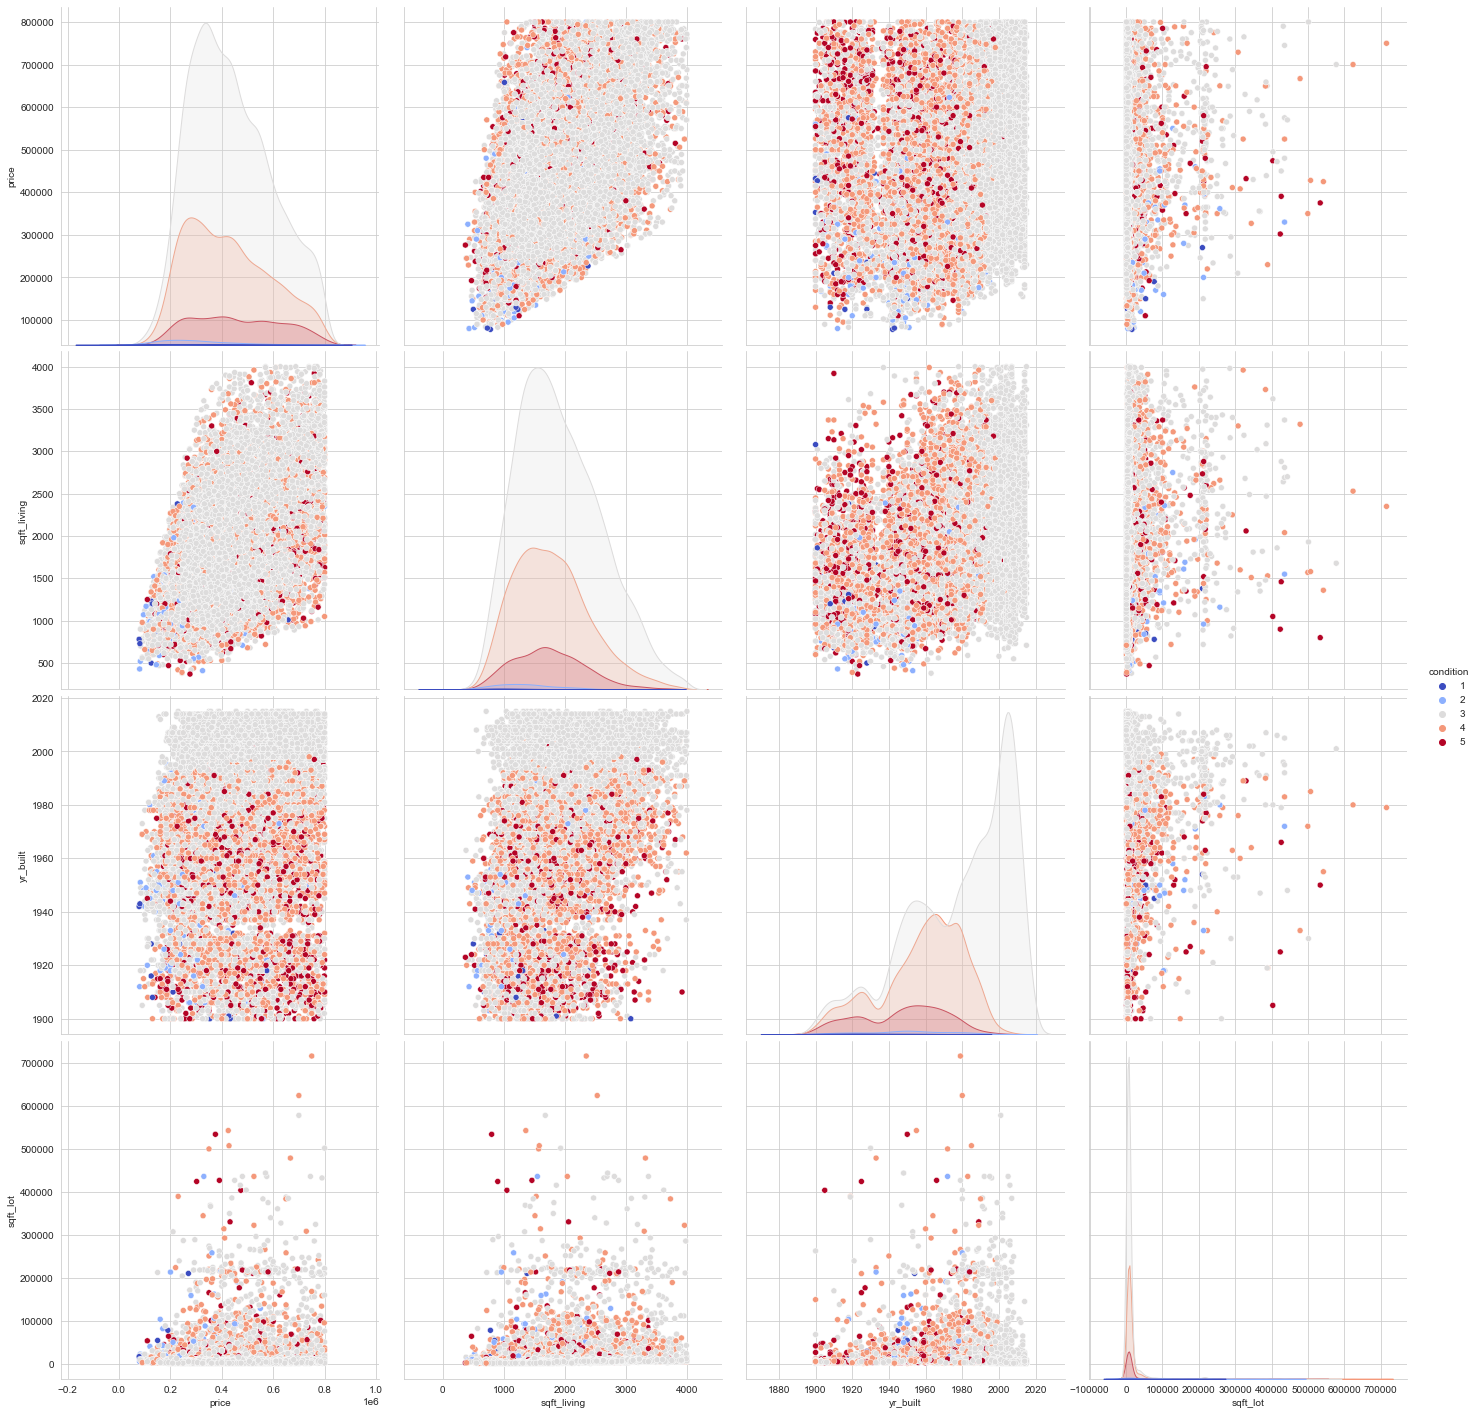

In [111]:
g = sns.pairplot(df_pairplot, hue= 'condition', palette= 'coolwarm', height= 5)

## Modeling and Prediction

### First Model

In [112]:
df5 = df4.copy()

In [113]:
df5.drop(['id', 'zipcode'], axis= 1, inplace= True)

In [114]:
outcome = 'price'
x_cols = df5.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula= f, data= df5).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1082.
Date:                Sat, 09 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:44:38   Log-Likelihood:            -2.3650e+05
No. Observations:               18352   AIC:                         4.731e+05
Df Residuals:                   18320   BIC:                         4.733e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4.712e+07   3.16e+06    -14.895      0.000   -5.33e+07   -4.09e+07
sqft_living       76.4408      1.928     39.645      0.000      72.661      80.220
sqft_lot           0.2438      0.023     10.442      0.000       0.198       0.290
waterfront      1.375e+05   1.65e+04      8.337      0.000    1.05e+05     1.7e+05
condition       2.248e+04   1209.801     18.585      0.000    2.01e+04    2.49e+04
yr_built       -1251.9628     37.882    -33.049      0.000   -1326.216   -1177.710
lat             4.978e+05   5240.402     95.001      0.000    4.88e+05    5.08e+05
long            4.928e+04   6016.155      8.192      0.000    3.75e+04    6.11e+04
year_sold       1.595e+04   1512.976     10.543      0.000     1.3e+04    1.89e+04
has_basement    1.382e+04   1752.391      7.887      0.000    1.04e+04    1.73e+04
has_view        6.028e+04   3070.101     19.633      0.000    5.43e+04    6.63e+04
had_renovation  1.313e+04   4570.491      2.874      0.004    4175.062    2.21e+04
bed_2           6910.4527   7376.126      0.937      0.349   -7547.444    2.14e+04
bed_3          -4774.5351   7370.799     -0.648      0.517   -1.92e+04    9672.919
bed_4          -9804.8098   7575.073     -1.294      0.196   -2.47e+04    5043.041
bed_5          -2.617e+04   8168.594     -3.203      0.001   -4.22e+04   -1.02e+04
bed_6          -3.003e+04   1.09e+04     -2.767      0.006   -5.13e+04   -8757.910
bath_2          1.551e+04   1990.612      7.794      0.000    1.16e+04    1.94e+04
bath_3          2.646e+04   3683.859      7.182      0.000    1.92e+04    3.37e+04
bath_4          2.039e+04    1.4e+04      1.457      0.145   -7033.459    4.78e+04
bath_5          8.884e+04   3.99e+04      2.226      0.026    1.06e+04    1.67e+05
flr_2           2.966e+04   1806.631     16.415      0.000    2.61e+04    3.32e+04
flr_3           4.906e+04   4506.465     10.887      0.000    4.02e+04    5.79e+04
flr_4           7.038e+04   3.92e+04      1.797      0.072   -6379.089    1.47e+05
grd_4          -1.392e+05   9.76e+04     -1.427      0.154    -3.3e+05     5.2e+04
grd_5          -1.337e+05   9.61e+04     -1.392      0.164   -3.22e+05    5.46e+04
grd_6          -1.031e+05    9.6e+04     -1.074      0.283   -2.91e+05    8.51e+04
grd_7          -3.646e+04    9.6e+04     -0.380      0.704   -2.25e+05    1.52e+05
grd_8           3.441e+04   9.61e+04      0.358      0.720   -1.54e+05    2.23e+05
grd_9           1.101e+05   9.61e+04      1.146      0.252   -7.82e+04    2.99e+05
grd_10            1.6e+05   9.62e+04      1.662      0.096   -2.87e+04    3.49e+05
grd_11           1.91e+05   9.92e+04      1.925      0.054   -3511.637    3.85e+05
==============================================================================
Omnibus:                      551.192   Durbin-Watson:                   2.010
Prob(Omnibus):      

### Log Transform

### Train test split

### Improving baseline model

In [115]:
# get rid of columns you won't use
# https://www.youtube.com/watch?v=8_Le51miL-8
# https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

In [116]:
# log transform

In [117]:
# df2 = df1[['price', 'waterfront', 'yr_built', 'sqft_living15', 'zipcode']]

In [118]:
# pd.plotting.scatter_matrix(df2, figsize= [11,11]);

In [119]:
# df['zipcode'].hist()
# plt.show()

In [120]:
# df.groupby('lat')['sqft_living'].mean().nlargest(5)
# df.groupby('lat')['sqft_living'].mean().min()
# df.groupby('long')['sqft_living'].mean().max()
# df.loc[(df['sqft_living'] <= 1200) & (df['sqft_living15'] > 2000)]
# df.loc[(df['sqft_living'] >= 3000)]
# df.groupby('long')['sqft_living'].mean().nlargest(5)

# for reference - delete when finished
# df_id_dups.groupby('date')['id'].count()
# df_id_dups= df_id_dups.groupby(['id']).unique().count()

In [121]:
# create boxplot with all columns
# sns.boxplot(data=df, orient= 'h')

# # drop price, sqft_lot, zipcode, and sqft_lot15 to see rest of columns better
# boxplot_df.drop(['price', 'sqft_lot', 'sqft_lot15', 'zipcode'], axis= 1, inplace= True)

# # plot only one column in boxplot
# print (df['price'].nlargest(5))
# sns.boxplot(x= df['price'])

In [122]:
# z test, z score
# How to remove everything after 2 standard deviations - can also use lambda
# df = df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]
# df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]

#can filter by column too - here "B" is name of column
# df[((df.B - df.B.mean()) / df.B.std()).abs() < 2]

In [123]:
# First, let's look at houses that were built from 1900 - 1940 that
# had renovations since the year 2000
# reno_1940 = len(df.loc[(df['yr_built'] <= 1940) & (df['yr_renovated'] >= 2000)])
# print('# of houses built before 1940 that had renovation within 15 years:', 
#       reno_1940)
# print('% of houses that had recent reno and built before 1940: ',
#      reno_1940 / len(df['yr_built']))